In [21]:
import dataloader
from dataloader import clean_text, lemmatize_text
from textaug import text_aug

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [2]:
enc = LabelEncoder()

file_list = dataloader.csv_concat(dataloader.DATA_PATH)
df = dataloader.file_structuring(file_list)

code_enc = enc.fit_transform(df.codes)
df["code_enc"] = code_enc

df.head()

,notes,codes,desc,code_enc
0,Patient underwent surgical intervention for St...,M00.0,Staphylococcal arthritis and polyarthritis,0
1,Operative note: Patient presented with Staphyl...,M00.0,Staphylococcal arthritis and polyarthritis,0
2,Operative intervention performed for Staphylo...,M00.0,Staphylococcal arthritis and polyarthritis,0
3,Patient underwent surgical management for Stap...,M00.0,Staphylococcal arthritis and polyarthritis,0
4,Surgical intervention performed for Staphyloco...,M00.0,Staphylococcal arthritis and polyarthritis,0


In [3]:
print(df.isna().sum())

df.dropna(inplace=True)

print(df.isna().sum())

notes       9
codes       0
desc        0
code_enc    0
dtype: int64
notes       0
codes       0
desc        0
code_enc    0
dtype: int64


In [4]:
df.drop_duplicates(inplace=True)

<AxesSubplot:>

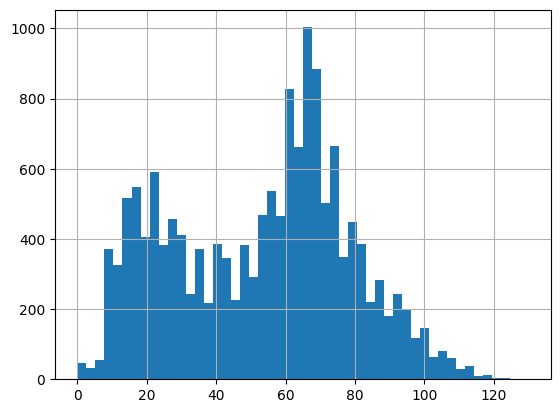

In [5]:
df['Word_Count'] = df['notes'].apply(lambda x: len(x.split()))
df.Word_Count.hist(bins=50)

In [6]:
words_to_exclude = ['Certainly!']
df = df[~df['notes'].str.contains('|'.join(words_to_exclude))].copy()

word_to_remove = ["1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10.", 'Certainly!', '00', '00 00', '00 00 00']
for w in word_to_remove:
    df['notes'] = df['notes'].str.replace(w, '')

df = df[df['Word_Count'] >= 10]
df.shape

(15167, 5)

In [24]:
#binarize the dataset
M45 = df[df.codes == "M45"]
M45.codes = int(1)
other = df[df.codes != "M45"]
other.codes = 0
other = other.sample(frac=0.1)
other = other[:300]

sample = pd.concat([M45, other]).sample(frac=23)
sample.head()

,notes,codes,desc,code_enc,Word_Count
98,Operative Note lxii: Contracture release surge...,0,Contracture of muscle,50,80
222,"The patient was placed in a supine position, a...",0,Other rupture of muscle (nontraumatic),47,40
385,Ankylosing spondylitis patient showed progres...,1,Ankylosing spondylitis,29,44
146,There are A woman with AS is presented with r...,1,Ankylosing spondylitis,29,12
173,This operative promissory note documents the ...,0,Infective myositis,36,99


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

def gen_embeddings(df, 
               X_features=sample['notes'],
               y_features=sample['code_enc'], 
               test_size=0.2,
               max_features=1000, 
               random_state=23):


    vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), 
                                 max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)

    tfIdfMat  = vectorizer.fit_transform(X_features.tolist())
    feature_names = sorted(vectorizer.get_feature_names_out())



    pca = PCA(n_components=2, random_state=23)
    tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
    labels = y_features.tolist()
    category_list = y_features.unique()


    X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, 
                                                        test_size=test_size, 
                                                        stratify=labels,
                                                        random_state=random_state)
    
    return (X_train, X_test, y_train, y_test, vectorizer, feature_names, pca, labels, category_list)
    
    

X_train, X_test, y_train, y_test, vectorizer, feature_names, pca, labels, category_list = gen_embeddings(sample)

print(X_train.shape, X_test.shape)

(3033, 2) (759, 2)


In [60]:
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

In [61]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [ ]:
figure = plt.figure(figsize=(27, 9))
i = 1


for ds_cnt, ds in enumerate(df):
    

    x_min, x_max = X_train[:, 1].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(sample), len(classifiers) + 1, i)
    
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1


    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(sample), len(classifiers) + 1, i)

        clf = make_pipeline(clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(clf, X_train)
        
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k",alpha=0.6)

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right"y)
        i += 1

plt.tight_layout()
plt.show()

In [58]:
X_train.shape

(3033, 547)